In [7]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Build Pandas Dataframe

In [2]:
dataset_name_clean = "data_full_clean.txt"
dataset_path = ".\\data\\"

with open(dataset_path+dataset_name_clean) as json_file:
    data = json.load(json_file)

In [3]:
# Get column names
columns = list(data['0'].keys())
columns.remove('album_url')

records = []

for item in data.keys():
    record = []
    for col in columns:
        record.append(data[item][col])
    records.append(record)

albums_df = pd.DataFrame(records, columns=columns)
albums_df.head()

,artist_id,artist_name,album_id,album_name,album_popularity,genres,filepath
0,5me0Irg2ANcsgc93uaYrpb,The Notorious B.I.G.,7dRdaGSxgcBdJnrOviQRuB,Life After Death (2014 Remastered Edition),78,"[east coast hip hop, gangster rap, hardcore hi...",.\images\7dRdaGSxgcBdJnrOviQRuB.jpg
1,36QJpDe2go2KgaRleHCDTp,Led Zeppelin,6P5QHz4XtxOmS5EuiGIPut,Led Zeppelin III (Remaster),74,"[album rock, classic rock, hard rock, rock]",.\images\6P5QHz4XtxOmS5EuiGIPut.jpg
2,5WUlDfRSoLAfcVSX1WnrxN,Sia,77jAfTh3KH9K2reMOmTgOh,This Is Acting,74,"[australian dance, australian pop, dance pop, ...",.\images\77jAfTh3KH9K2reMOmTgOh.jpg
3,0dEvJpkqhrcn64d3oI8v79,Barenaked Ladies,0DuFDnZcj7B4R0Jik1aDmY,Stunt (20th Anniversary Edition),66,"[canadian pop, canadian rock, comic, pop rock]",.\images\0DuFDnZcj7B4R0Jik1aDmY.jpg
4,2BvzbqWWwLN11XGBYgDZzx,Terror Squad,0NTYMm0B7adXejff1phD3F,True Story,60,"[bronx hip hop, hardcore hip hop]",.\images\0NTYMm0B7adXejff1phD3F.jpg


<AxesSubplot:xlabel='album_popularity'>

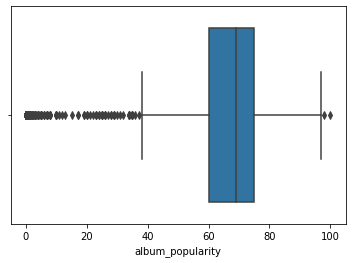

In [4]:
sns.boxplot(x=albums_df['album_popularity'])

<AxesSubplot:>

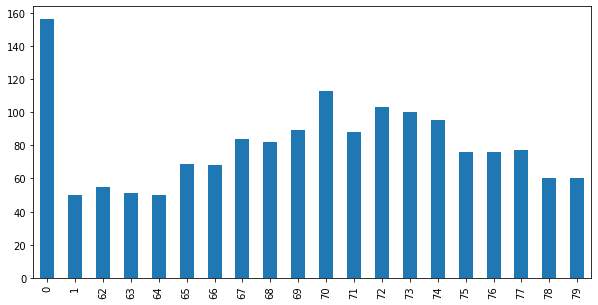

In [5]:
r = albums_df.album_popularity.value_counts().sort_index()
r.nlargest(20).sort_index().plot(kind='bar', figsize=(10,5))

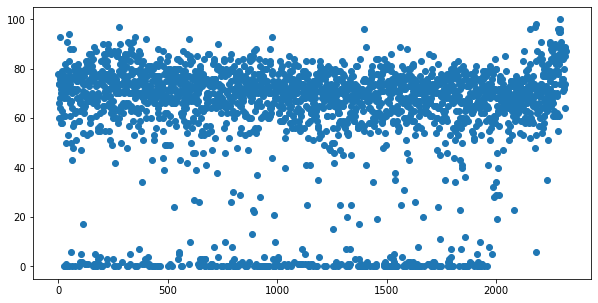

In [8]:
# Plotting a scatter plot
fig, ax = plt.subplots(figsize=(10,5))
x = albums_df.album_popularity
y = x.index
ax.scatter(y, x)


plt.show()